# 样式迁移

喜欢拍照的同学可能都接触过滤镜，它们能改变照片的颜色风格，可以使得风景照更加锐利或者人像更加美白。但一个滤镜通常只能改变照片的某个方面，达到想要的风格经常需要大量组合尝试，其复杂程度不亚于模型调参。

本小节我们将介绍如何使用神经网络来自动化这个过程 [1]。这里我们需要两张输入图像，一张是内容图像，另一张是样式图像，我们将使用神经网络修改内容图像使得其样式接近样式图像。图 9.12 中的内容图像为本书作者在西雅图郊区的雷尼尔山国家公园（Mount Rainier National Park）拍摄的风景照，样式图像则为一副主题为秋天橡树的油画，其合成图像在保留了内容图像中物体主体形状的情况下加入了样式图像的油画笔触，同时也让整体颜色更加鲜艳。

![输入内容图像和样式图像，输出样式迁移后的合成图像。](../img/style-transfer.svg)


使用神经网络进行样式迁移的过程如图 9.13 所示。在图中我们选取一个有三个卷积层的神经网络为例，来提取特征。对于样式图像，我们选取第一和第三层输出作为样式特征。对于内容图像则选取第二层输出作为内容特征。给定一个合成图像的初始值，我们通过不断的迭代直到其与样式图像输入到同一神经网络时，第一和第三层输出能很好地匹配样式特征，并且合成图像与初始内容图像输入到神经网络时在第二层输出能匹配到内容特征。

![使用神经网络进行样式迁移。](../img/neural-style.svg)

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import gluonbook as gb
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import model_zoo, nn
import time

## 数据

我们分别读取样式和内容图像。

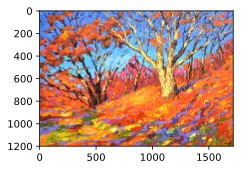

In [2]:
gb.set_figsize()
style_img = image.imread('../img/autumn_oak.jpg')
gb.plt.imshow(style_img.asnumpy());

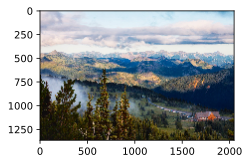

In [3]:
content_img = image.imread('../img/rainier.jpg')
gb.plt.imshow(content_img.asnumpy());

然后定义预处理和后处理函数。预处理函数将原始图像进行归一化并转换成卷积网络接受的输入格式，后处理函数则还原成能展示的图像格式。

In [4]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

## 抽取特征

我们使用原论文使用的 VGG-19 模型，并下载在 ImageNet 上训练好的权重 [1]。

In [5]:
pretrained_net = model_zoo.vision.vgg19(pretrained=True)

我们知道 VGG 使用了五个卷积块来构建网络，块之间使用最大池化层来做间隔（参考[“使用重复元素的网络（VGG）”](../chapter_convolutional-neural-networks/vgg.md)小节）。原论文中使用每个卷积块的第一个卷积层输出来匹配样式（称之为样式层），和第四块中的最后一个卷积层来匹配内容（称之为内容层）[1]。我们可以打印`pretrained_net`来获取这些层的具体位置。

In [6]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

当然，样式层和内容层有多种选取方法。通常越靠近输入层越容易匹配内容和样式的细节信息，越靠近输出则越倾向于语义的内容和全局的样式。这里我们选取比较靠后的内容层，以避免合成图像保留过多内容图像的细节。使用多个位置的样式层来匹配局部和全局样式。

下面构建一个新的网络使其只保留我们需要预留的层。

In [7]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

给定输入`x`，简单使用`net(x)`只能拿到最后的输出，而这里我们还需要中间层输出。因此我们逐层计算，并保留样式层和内容层的输出。

In [8]:
def extract_features(x, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        x = net[i](x)
        if i in style_layers:
            styles.append(x)
        if i in content_layers:
            contents.append(x)
    return contents, styles

最后我们定义函数分别对内容图像和样式图像抽取对应的特征。因为在训练时我们不修改网络的权重，所以可以在训练开始之前就提取出所要的特征。

In [9]:
def get_contents(image_shape, ctx):
    content_x = preprocess(content_img, image_shape).copyto(ctx)
    content_y, _ = extract_features(content_x, content_layers, style_layers)
    return content_x, content_y

def get_styles(image_shape, ctx):
    style_x = preprocess(style_img, image_shape).copyto(ctx)
    _, style_y = extract_features(style_x, content_layers, style_layers)
    return style_x, style_y

## 损失函数

在训练时，我们需要定义如何比较合成图像和内容图像的内容层输出（内容损失函数），以及比较和样式图像的样式层输出（样式损失函数）。内容损失函数可以使用回归用的均方误差。

In [10]:
def content_loss(y_hat, y):
    return (y_hat - y).square().mean()

对于样式，我们可以简单将它看成是像素点在每个通道的统计分布。例如要匹配两张图像的样式，我们可以匹配这两张图像在 RGB 这三个通道上的直方图。更一般的，假设卷积层的输出格式是 $c \times h \times w$，既（通道，高，宽）。那么我们可以把它变形成 $c \times hw$ 的二维数组，并将它看成是一个维度为 $c$ 的随机变量采样到的 $hw$ 个点。所谓的样式匹配就是使得两个 $c$ 维随机变量统计分布一致。

匹配统计分布常用的做法是冲量匹配，就是说使得他们有一样的均值，协方差，和其他高维的冲量。为了计算简单起见，我们只匹配二阶信息，即协方差。下面定义如何计算协方差矩阵，

In [11]:
def gram(x):
    c, n = x.shape[1], x.size // x.shape[1]
    y = x.reshape((c, n))
    return nd.dot(y, y.T) / (c * n)

和对应的损失函数，这里假设样式图像的样式特征协方差已经预先计算好了。

In [12]:
def style_loss(y_hat, gram_y):
    return (gram(y_hat) - gram_y).square().mean()

当我们使用靠近输出层的神经层输出来匹配时，经常可以观察到学到的合成图像里面有大量高频噪音，即有特别亮或者暗的颗粒像素。一种常用的降噪方法是总变差降噪（total variation denoising）。假设 $x_{i,j}$ 表示像素 $(i,j)$ 的值，总变差损失使得邻近的像素值相似：

$$\sum_{i,j} \left|x_{i,j} - x_{i+1,j}\right| + \left|x_{i,j} - x_{i,j+1}\right|.$$

In [13]:
def tv_loss(y_hat):
    return 0.5 * ((y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]).abs().mean() +
                  (y_hat[:, :, :, 1:] - y_hat[:, :, :, :-1]).abs().mean())

训练中我们将上述三个损失函数加权求和。通过调整权重值我们可以控制学到的图像是否保留更多样式，更多内容，还是更加干净。

In [14]:
style_channels = [net[l].weight.shape[0] for l in style_layers]
style_weights = [1e3] * len(style_channels)
content_weights, tv_weight = [1], 10

## 训练

这里的训练跟前面章节的主要不同在于我们只对输入`x`进行更新。此外我们将`x`的梯度除以它的绝对平均值来降低对学习率的敏感度，而且每隔一定的批量我们减小一次学习率。

In [15]:
class TransferredImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(TransferredImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()


def train(x, content_y, style_y, ctx, lr, max_epochs, lr_decay_epoch):
    net = TransferredImage(x.shape)
    net.initialize(init.Constant(x), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    x = net()

    style_y_gram = [gram(y) for y in style_y]
    for i in range(max_epochs):
        tic = time.time()
        with autograd.record():
            # 对 x 抽取样式和内容特征。
            content_y_hat, style_y_hat = extract_features(
                x, content_layers, style_layers)
            # 分别计算内容、样式和噪音损失。
            content_L = [w * content_loss(y_hat, y) for w, y_hat, y in zip(
                content_weights, content_y_hat, content_y)]
            style_L = [w * style_loss(y_hat, y) for w, y_hat, y in zip(
                style_weights, style_y_hat, style_y_gram)]
            tv_L = tv_weight * tv_loss(x)
            # 对所有损失求和。
            l = nd.add_n(*style_L) + nd.add_n(*content_L) + tv_L
        l.backward()     
        trainer.step(1)
        # 如果不加的话会导致每 50 轮迭代才同步一次，可能导致过大内存使用。
        nd.waitall()

        if i % 50 == 0:
            print('batch %3d: content %.2f, style %.2f, '
                  'TV %.2f, %.1f sec per batch'
                  % (i, nd.add_n(*content_L).asscalar(),
                     nd.add_n(*style_L).asscalar(), tv_L.asscalar(),
                     time.time() - tic))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return net()

现在我们可以真正开始训练了。首先将图像调整到高 300 宽 200，这样能使训练更加快速。合成图像的初始值设成了内容图像，使得初始值能尽可能接近训练输出，从而加速收敛。

In [16]:
ctx, image_shape = gb.try_gpu(), (300, 200)
net.collect_params().reset_ctx(ctx)
content_x, content_y = get_contents(image_shape, ctx)
style_x, style_y = get_styles(image_shape, ctx)

x = content_x
y = train(x, content_y, style_y, ctx, 0.01, 500, 200)

batch   0: content 0.00, style 372.72, TV 2.13, 5.2 sec per batch


batch  50: content 11.92, style 28.25, TV 3.13, 0.0 sec per batch


batch 100: content 8.96, style 13.67, TV 3.32, 0.0 sec per batch


batch 150: content 7.52, style 10.24, TV 3.40, 0.0 sec per batch


batch 200: content 6.67, style 8.28, TV 3.47, 0.0 sec per batch
change lr to 1.0e-03


batch 250: content 6.58, style 8.10, TV 3.48, 0.0 sec per batch


batch 300: content 6.50, style 7.93, TV 3.49, 0.0 sec per batch


batch 350: content 6.42, style 7.76, TV 3.49, 0.0 sec per batch


batch 400: content 6.34, style 7.59, TV 3.50, 0.0 sec per batch
change lr to 1.0e-04


batch 450: content 6.33, style 7.57, TV 3.50, 0.0 sec per batch


因为使用了内容图像作为初始值，所以一开始内容误差远小于样式误差。随着迭代的进行样式误差迅速减少，最终它们值在相近的范围。下面我们将训练好的合成图像保存下来。

In [17]:
gb.plt.imsave('../img/neural-style-1.png', postprocess(y).asnumpy())

![$300 \times 200$ 尺寸的合成图像。](../img/neural-style-1.png)

可以看到图 9.14 中的合成图像保留了样式图像的风景物体，同时借鉴了样式图像的色彩。由于图像尺寸较小，所以细节上比较模糊。下面我们在更大的 $1200 \times 800$ 的尺寸上训练，希望可以得到更加清晰的合成图像。为了加速收敛，我们将训练到的合成图像高宽放大 3 倍来作为初始值。

In [18]:
image_shape = (1200, 800)

content_x, content_y = get_contents(image_shape, ctx)
style_x, style_y = get_styles(image_shape, ctx)

x = preprocess(postprocess(y) * 255, image_shape)
z = train(x, content_y, style_y, ctx, 0.01, 300, 100)

gb.plt.imsave('../img/neural-style-2.png', postprocess(z).asnumpy())

batch   0: content 16.82, style 216.87, TV 0.68, 3.4 sec per batch


batch  50: content 10.02, style 8.30, TV 1.38, 0.2 sec per batch


batch 100: content 7.16, style 4.88, TV 1.50, 0.2 sec per batch
change lr to 1.0e-03


batch 150: content 6.94, style 4.73, TV 1.50, 0.2 sec per batch


batch 200: content 6.76, style 4.61, TV 1.50, 0.2 sec per batch
change lr to 1.0e-04


batch 250: content 6.73, style 4.59, TV 1.51, 0.2 sec per batch


可以看到这一次由于初始值离最终输出更近使得收敛更加迅速。但同时由于图像尺寸更大，每一次迭代需要花费更多的时间和内存。

![$1200 \times 800$ 尺寸的合成图像。](../img/neural-style-2.png)

从训练得到的图 9.15 中的可以看到它保留了更多的细节，里面不仅有大块的类似样式图像的油画色彩块，色彩块里面也有细微的纹理。

## 小结

* 通过匹配神经网络的中间层输出可以有效的融合不同图像的内容和样式。

## 练习

* 选择不同的内容和样式层。
* 使用不同的损失权重来得到更偏向内容或样式或平滑的输出。
* 一个得到更加干净的合成图的办法是使用更大的尺寸。
* 换别的样式和内容图像试试。

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/3273)

![](../img/qr_neural-style.svg)

## 参考文献

[1] Gatys, L. A., Ecker, A. S., & Bethge, M. (2016). Image style transfer using convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 2414-2423).